## Load Dataset

In [28]:
import psycopg2
import pandas as pd
import json

conn = psycopg2.connect(
    dbname="scientilla",
    user="postgres",
    password="pwd",
    host="localhost",
    port=5444
)
cur = conn.cursor()

query = """
SELECT ri.id, ri.data
FROM research_item AS ri
JOIN research_item_type AS rit
    ON ri.research_item_type_id = rit.id
WHERE rit.type = 'publication'
ORDER BY ri.id
LIMIT 100;
"""

df = pd.read_sql(query, conn)
print(df)

ids = df["id"].tolist()
data_array = df["data"].tolist()


      id                                               data
0   1786  {'doi': '10.1016/j.jconrel.2011.10.021', 'year...
1   1787  {'doi': '10.1002/adfm.202400982', 'year': '202...
2   1788  {'doi': '10.1016/j.jnucmat.2024.155121', 'year...
3   1789  {'doi': '10.1103/PhysRevB.94.165155', 'year': ...
4   1790  {'doi': '10.1039/c2jm15117k', 'year': '2012', ...
..   ...                                                ...
95  1881  {'doi': '10.3390/s150304913', 'year': '2015', ...
96  1882  {'doi': '10.1002/app.55527', 'year': '2024', '...
97  1883  {'doi': '10.1515/nanoph-2019-0199', 'year': '2...
98  1884  {'doi': '10.1093/nar/gkae172', 'year': '2024',...
99  1885  {'doi': '10.1021/acsenergylett.8b00193', 'year...

[100 rows x 2 columns]


/tmp/ipykernel_9383/3461381595.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Preprocessing

In [29]:
def clean_item(item):
    title = item.get("title") or ""
    abstract = item.get("abstract") or ""
    title = item.get("title") or ""
    abstract = item.get("abstract") or ""
    if abstract:
      text = f"{title}. {abstract}"
    else:
      text = f"{title}."
    return text.strip()

cleaned_strings = [clean_item(d) for d in data_array]

for s in cleaned_strings:
    print(s)

Rapid tumoritropic accumulation of systemically injected plateloid particles and their biodistribution. Nanoparticles for cancer therapy and imaging are designed to accumulate in the diseased tissue by exploiting the Enhanced Permeability and Retention (EPR) effect. This limits their size to about 100 nm. Here, using intravital microscopy and elemental analysis, we compare the in vivo localization of particles with different geometries and demonstrate that plateloid particles preferentially accumulate within the tumor vasculature at unprecedented levels, independent of the EPR effect. In melanoma-bearing mice, 1000 × 400 nm plateloid particles adhered to the tumor vasculature at about 5% and 10% of the injected dose per gram organ (ID/g) for untargeted and RGD-targeted particles respectively, and exhibited the highest tumor-to-liver accumulation ratios (0.22 and 0.35). Smaller and larger plateloid particles, as well as cylindroid particles, were more extensively sequestered by the live

## Dataset Embedding Generation

In [30]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

model = SentenceTransformer("sentence-transformers/allenai-specter")

doc_texts = [json.dumps(d, ensure_ascii=False) for d in data_array]

doc_embeddings = model.encode(
    doc_texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)

#### Save to file

In [31]:
# doc_ids = [d.get("doi") or f"idx_{i}" for i, d in enumerate(data_array)]
# np.save("embeddings/doc_embeddings_specter2.npy", doc_embeddings)
# 
# with open("doc_ids.json", "w", encoding="utf-8") as f:
#     json.dump(doc_ids, f, ensure_ascii=False, indent=2)
# 
# print("Saved doc_embeddings.npy and doc_ids.json")


#### Save to db

In [32]:
update_sql = """
UPDATE research_item
SET embedding = %s::vector
WHERE id = %s;
"""

for rid, emb in zip(ids, doc_embeddings):
    emb_list = emb.tolist()
    emb_str = "[" + ",".join(str(x) for x in emb_list) + "]"
    cur.execute(update_sql, (emb_str, rid))

conn.commit()
cur.close()

print("Embeddings stored in research_item.embedding")

Embeddings stored in research_item.embedding


### Clustering

/tmp/ipykernel_9383/3345095364.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", n_clusters)


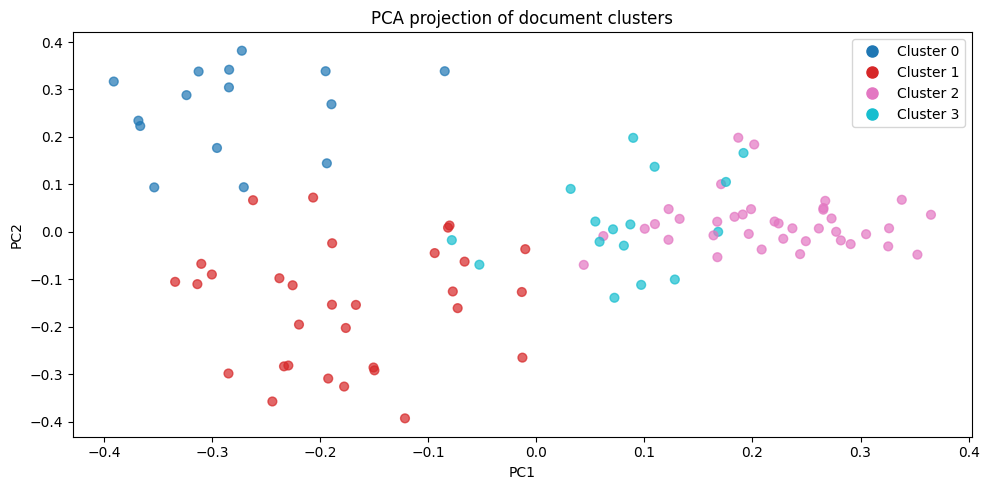


=== Cluster 0 ===
- Dynamic distributed intrusion detection for secure Multi-Robot systems
- Inconsistency of perceived 3D shape
- A Bioinspired Multifunctional Soft Gripper with Embedded Sensing Ability: A potential way for sustainable agricultural harvesting
- Robots trends and megatrends: artificial intelligence and the society
- A robot-based assessment of trunk control in Spinal Cord Injured athletes
- Modelling and control design of a novel robotic membrane
- Assessment of the Monitor System Interface: A Setup System Tool for Industrial Exoskeletons
- Autonomous Battery Exchange of UAVs with a Mobile Ground Base
- Computing the COM from the COP in postural sway movements
- Neuromotor control in handwriting and drawing: introduction and overview.
- ALICIA an architecture for intelligent affective agents
- Accurate trajectory transformations for redundant and nonredundant robots
- Guest Editorial Special Issue on Emerging Topics on Development and Learning
- Arm muscle synergies e

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm

titles = [d.get("title") or "" for d in data_array]  # extract titles

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(doc_embeddings)

cmap = cm.get_cmap("tab10", n_clusters)
colors = [cmap(l) for l in labels]

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()

# Print documents grouped by cluster
for c in range(n_clusters):
    print(f"\n=== Cluster {c} ===")
    indices = np.where(labels == c)[0]
    for idx in indices:
        print(f"- {titles[idx]}")


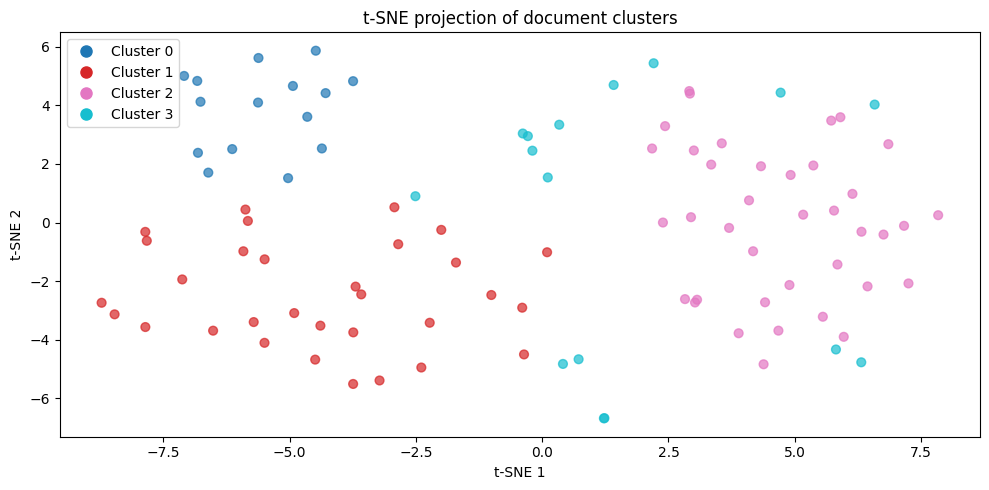

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
emb_2d_tsne = tsne.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d_tsne[:, 0],
    emb_2d_tsne[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()


## Testing

#### From file

In [35]:
# import numpy as np
# import json
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity
# 
# model = SentenceTransformer("sentence-transformers/allenai-specter")
# 
# doc_embeddings = np.load("embeddings/doc_embeddings_specter2.npy")
# 
# with open("doc_ids.json", "r", encoding="utf-8") as f:
#     doc_ids = json.load(f)


In [36]:
# from sklearn.metrics.pairwise import cosine_similarity
# 
# def search(query, top_k=5):
#     q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
#     sims = cosine_similarity(q_emb, doc_embeddings)[0]
# 
#     ranked = np.argsort(-sims)
#     k = min(top_k, len(ranked))
# 
#     print(f"\n=== Query: {query!r} ===")
#     for i in range(k):
#         idx = ranked[i]
#         score = sims[idx]
#         doc_id = doc_ids[idx]
#         text = cleaned_strings[idx]
# 
#         print(f"\n[{i+1}] id={doc_id}  score={score:.3f}")
#         print(f"     text: {text[:200]}{'...' if len(text) > 200 else ''}")
# test_queries = ['renewable energies','heart', 'cardiology', 'nature','biology']
# 
# for q in test_queries:
#     search(q, top_k=5)

#### From db

In [37]:

def embedding_to_pgvector_str(vec):
    """From np.array to string '[v1,v2,...]' for ::vector."""
    return "[" + ",".join(str(float(x)) for x in vec.tolist()) + "]"

def search(query, top_k=5):
    # query embedding
    q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
    q_emb_str = embedding_to_pgvector_str(q_emb)

    # SQL query with pgvector cosine distance
    sql = """
    WITH q AS (
        SELECT %s::vector AS emb
    )
    SELECT
        ri.id,
        ri.data,
        ri.embedding <=> q.emb AS distance
    FROM research_item AS ri
    JOIN research_item_type AS rit
        ON ri.research_item_type_id = rit.id
    JOIN q
        ON TRUE
    WHERE rit.type = 'publication'
      AND ri.embedding IS NOT NULL
    ORDER BY ri.embedding <=> q.emb
    LIMIT %s;
    """

    with conn.cursor() as cur:
        cur.execute(sql, (q_emb_str, top_k))
        rows = cur.fetchall()

    print(f"\n=== Query: {query!r} ===")

    for i, (doc_id, data_json, distance) in enumerate(rows, start=1):
        # Convert distance to similarity score
        score = 1.0 - float(distance)

        text = clean_item(data_json)
        preview = text[:200] + ("..." if len(text) > 200 else "")

        print(f"\n[{i}] id={doc_id}  score={score:.3f}")
        print(f"     text: {preview}")


In [38]:
test_queries = ['renewable energies','heart', 'cardiology', 'nature','biology']

for q in test_queries:
    search(q, top_k=5)


=== Query: 'renewable energies' ===

[1] id=1846  score=0.703
     text: IBIC analysis of CdTe/CdS solar cells. This paper reports on the investigation of the electronic properties of a thin film CdS/CdTe solar cell with the Ion Beam Induced Charge (IBIC) technique. The de...

[2] id=1790  score=0.697
     text: Aqueous processing of cellulose based paper-anodes for flexible Li-ion batteries. Cellulose fibers were used as novel bio-sourced binder to manufacture flexible cellulose/graphite paper-anodes for Li-...

[3] id=1806  score=0.676
     text: An organic artificial soma for spatio-temporal pattern recognition via dendritic integration. A novel organic neuromorphic device performing pattern classification is presented and demonstrated. It fe...

[4] id=1858  score=0.675
     text: One-Pot Microwave-Assisted Synthesis of Reduced Graphene Oxide/Iron Oxide Nanocomposite Catalyst for the Oxygen Reduction Reaction. © 2016 WILEY-VCH Verlag GmbH & Co. KGaA, WeinheimWe report on a reli...